<a href="https://colab.research.google.com/github/oskargirardin/CRP_GDPR_datasets/blob/master/use_cases/fraud_detection/article/FD_ARTICLE_PT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FRAUD DETECTION ARTICLE - SUPPORTING NOTEBOOK - PART 1**

In this notebook, you will find the code that generates the results showcased in the article **"FILL IN ARTICLE NAME"** (LINK TO THE ARTICLE TO BE INSERTED) by SIA Partners in collaboration with students from Essec & Centrale Supélec.

The first part is dedicated to the ***import and preprocessing*** of the data, while the second on is dedicated to ***benchmarking the performance*** of the models trained on the different types of augmentation (no augmentation, SMOTE and synthetic generation). 

In order to run the notebook requires the following resources: 

*   Kaggle json file to download the dataset
*   The `generator.py` and the `SimilairtyCheck.py` files 


The two Python files and their documentation can be found in the following GitHub repository: add link 

For any questions or remarks, please contact xx@xx.com.link text

## Importing libraries and data

In [ ]:
!pip install torch==1.13.1
! pip install sdv
! pip install faker
! pip install realtabformer

In [ ]:
pip install --upgrade accelerate

In [ ]:
#Not run unless issues with Numpy
!pip uninstall numpy
!pip install numpy

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# import libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


from generator import *
from SimilarityCheck import *

In [ ]:
#We are using a dataset from kaggle. Don't forget to load a kaggle.json file before running this cell

! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d incarnyx/car-insurance-fraud

!unzip car-insurance-fraud.zip

 55% 1.00M/1.82M [00:00<00:00, 2.03MB/s]
100% 1.82M/1.82M [00:00<00:00, 3.23MB/s]
Archive:  car-insurance-fraud.zip
  inflating: Dataset.xlsx            


## Loading the data

In [ ]:
df = pd.read_excel("Dataset.xlsx")
pd.set_option('display.max_columns', None)

## Data preprocessing

### Preprocessing support functions

In [ ]:
months = {
    'Jan' : 1,
    'Feb' : 2,
    'Mar' : 3,
    'Apr' : 4,
    'May' : 5,
    'Jun' : 6,
    'Jul' : 7,
    'Aug' : 8,
    'Sep' : 9, 
    'Oct' : 10,
    'Nov' : 11,
    'Dec' : 12
          }
months_proc = lambda x: months.get(x, 0)

D_o_w = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
          }
D_o_w_proc = lambda x: D_o_w.get(x, 0)

vehicle_prices = {
    'less than 20000': 1,
    '20000 to 29000' : 2,
    '30000 to 39000' : 3,
    '40000 to 59000' : 4,
    '60000 to 69000' : 5,
    'more than 69000': 6,
          }
vehicle_price_proc = lambda x: vehicle_prices.get(x, 0)

AgeOfVehicle_variants = {
    'new'         : 0.5,
    '2 years'     : 2,
    '3 years'     : 3,
    '4 years'     : 4,
    '5 years'     : 5,
    '6 years'     : 6,
    '7 years'     : 7,
    'more than 7' : 8.5,
          }
vehicle_age_proc = lambda x: AgeOfVehicle_variants[x]

age_variants = {
    '16 to 17'     : 1,
    '18 to 20'     : 2,
    '21 to 25'     : 3,
    '26 to 30'     : 4,
    '31 to 35'     : 5,
    '36 to 40'     : 6,
    '41 to 50'     : 7,
    '51 to 65'     : 8,
    'over 65'      : 9,
          }
age_proc = lambda x: age_variants[x]

#this function creates the dummies for 1 column
def create_dummy(col, df):
    df_dummy = pd.get_dummies(df[col], drop_first = True)
    df_dummy.columns = ['dum: ' + str(col) + ': ' + str(name) for name in df_dummy.columns]
    return df_dummy

#this function uses the previous function to create dummies for all columns that need them
def dummies(df):
    dummy_df = pd.DataFrame()
    object_cols = df.columns[df.dtypes == object]
    for col in object_cols:
        dummy_df = pd.concat([dummy_df, create_dummy(col, df)], axis = 1)
    
    df_out = pd.concat([df.drop(columns = object_cols), dummy_df.astype('int32')], axis = 1)
    return df_out.sort_index(ascending=False, axis=1)



def preprocessing(df):
  df = df.dropna(axis = 0)
  df = df[df['Age'] > 0.0]
  df['Month'] = df['Month'].apply(months_proc)
  df['MonthClaimed'] = df['MonthClaimed'].apply(months_proc)
  df['DayOfWeek'] = df['DayOfWeek'].apply(D_o_w_proc)
  df['DayOfWeekClaimed'] = df['DayOfWeekClaimed'].apply(D_o_w_proc)
  df['VehiclePrice'] = df['VehiclePrice'].apply(vehicle_price_proc)
  df['AgeOfVehicle'] = df['AgeOfVehicle'].apply(vehicle_age_proc)
  df['AgeOfPolicyHolder'] = df['AgeOfPolicyHolder'].apply(age_proc)
  df = dummies(df)
  return df


### Preprocessing

In [ ]:
df_p = preprocessing(df)

## Modeling

### Results evaluation functions

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

def eval_result(model, X_test, y_test, validation = False):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        pred = model.predict(X_test)

        print("\n", classification_report(y_test, pred, target_names = ['Not Fraud', 'Fraud']), "\n")

        display(pd.DataFrame(confusion_matrix(y_test, pred), 
                         columns = ['Predicted Not Fraud', 'Predicted Fraud'],
                         index = ['Not Fraud', 'Fraud']))
        
        print("\n")
        if hasattr(model, 'feature_importances_') and not validation:
            features = pd.DataFrame({
                'Variable'  :X_test.columns,
                'Importance':model.feature_importances_
            })
            features.sort_values('Importance', ascending=False, inplace=True)
            display(features.head(20))

        fpr, tpr, _ = roc_curve(y_test, pred)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve')
        plt.legend(loc="lower right")
        plt.show()

### Data Split

In [ ]:
data, validation = train_test_split(df_p, test_size = 0.3, random_state = 42)

In [ ]:
data_X = data.drop('FraudFound_P', axis = 1)
data_y = data['FraudFound_P']

val_X = validation.drop('FraudFound_P', axis = 1)
val_y = validation['FraudFound_P']

### Original data (not augmented)

#### XGBoost: AUC = 0.776


               precision    recall  f1-score   support

   Not Fraud       0.97      0.97      0.97      3183
       Fraud       0.57      0.58      0.57       208

    accuracy                           0.95      3391
   macro avg       0.77      0.78      0.77      3391
weighted avg       0.95      0.95      0.95      3391
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,3091,92
Fraud,87,121


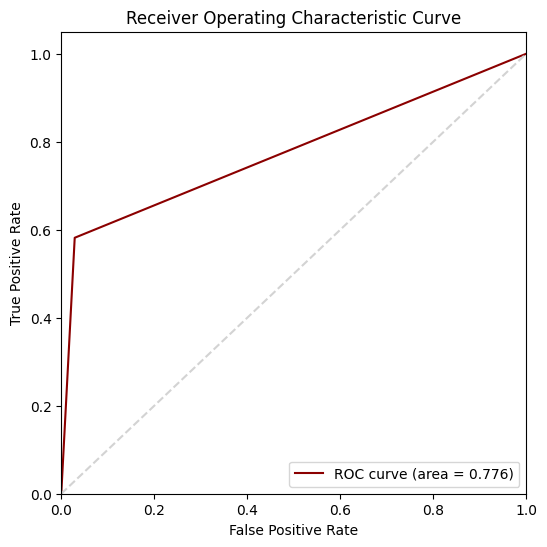

In [ ]:
xgbr = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    scale_pos_weight = 20,
    eval_metric = 'logloss'
)
xgbr.fit(data_X, data_y)
eval_result(xgbr, val_X, val_y, validation = True)

#### Decision Tree Classifier: AUC = 0.602


               precision    recall  f1-score   support

   Not Fraud       0.95      0.95      0.95      3183
       Fraud       0.27      0.25      0.26       208

    accuracy                           0.91      3391
   macro avg       0.61      0.60      0.61      3391
weighted avg       0.91      0.91      0.91      3391
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,3039,144
Fraud,156,52


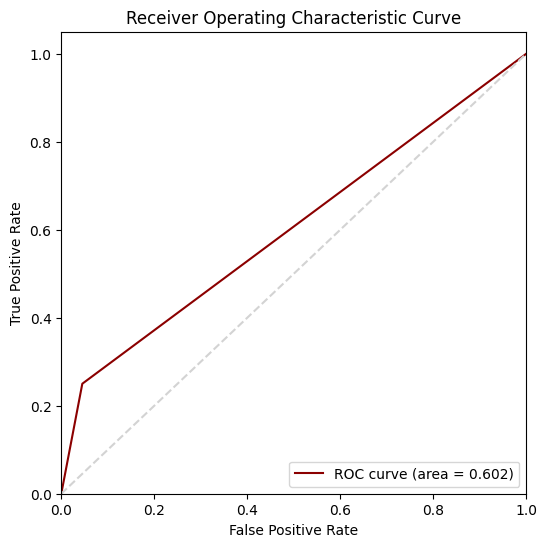

In [ ]:
dtc = DecisionTreeClassifier(random_state = 101)
dtc.fit(data_X, data_y)
eval_result(dtc, val_X, val_y, validation = True)

### Augmented data with SMOTE

#### Upsampling

In [ ]:
from imblearn.over_sampling import SMOTE

# we create the smote object (upsampling)
sm = SMOTE(random_state=42)

#upsampling the minority class
X_upsampled, y_upsampled = sm.fit_resample(data_X, data_y)

#### XGBoost: AUC = 0.727


               precision    recall  f1-score   support

   Not Fraud       0.97      0.96      0.96      3183
       Fraud       0.44      0.50      0.47       208

    accuracy                           0.93      3391
   macro avg       0.71      0.73      0.72      3391
weighted avg       0.93      0.93      0.93      3391
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,3054,129
Fraud,105,103


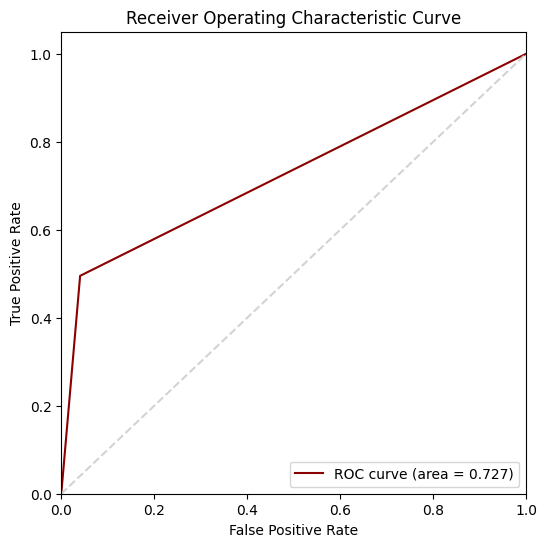

In [ ]:
xgbr_2 = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    scale_pos_weight = 20,
    eval_metric = 'logloss'
)
xgbr_2.fit(X_upsampled, y_upsampled)
eval_result(xgbr_2, val_X, val_y, validation = True)

#### Decision Tree Classifier: AUC = 0.585


               precision    recall  f1-score   support

   Not Fraud       0.95      0.93      0.94      3183
       Fraud       0.18      0.24      0.21       208

    accuracy                           0.89      3391
   macro avg       0.56      0.58      0.57      3391
weighted avg       0.90      0.89      0.89      3391
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,2956,227
Fraud,158,50


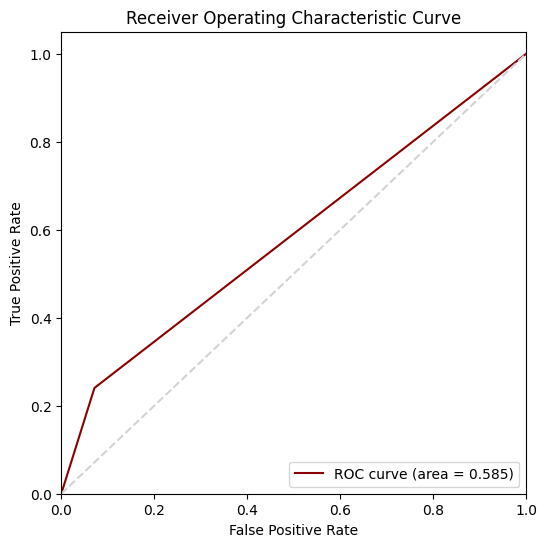

In [ ]:
dtc2 = DecisionTreeClassifier(random_state = 101)
dtc2.fit(X_upsampled, y_upsampled)
eval_result(dtc2, val_X, val_y, validation = True)

### Augmented data with synthetic generation (generation after preprocessing)

#### Samples generation

In order to augment the data using synthtic data generation the following steps are required:


1.   Take the `data` dataset and extract the minority class
2.   Create a synthetic sample similar to the minority class
3.   Merge the generated sample with the original dataset to form an *augmented set*.


It should be noted that we developed a funtion `augmentation` that does all of this automatically. The reason we are showing all the passages in this notebook is that we want to be able to perform similarity checks on the generated samples, and that would not be possible to do with the final output of this function. 

To have a better understanding of how to implement our functions please refer to the following GitHub repository:
[link to repository](https://)

In [ ]:
noffound = len(data[data['FraudFound_P']==0])
ffound = len(data[data['FraudFound_P']==1])
print("Data points where there is no fraud found: ", noffound, "\nData points where there is fraud found: ", ffound)

Data points where there is no fraud found:  7459 
Data points where there is fraud found:  451


In this case our objective is to augment the minority class so that its final size is approximately 20% of the majority class.

In [ ]:
s_size = round(noffound*0.2)-ffound
s_size

1041

In [ ]:
#Extracting the categorical columns
categorical_columns = []

for col in list(data):
    if data[col].dtypes == 'object':
        categorical_columns.append(col)

#Defining the sensitive columns
sensitive_columns = ['dum: MaritalStatus: Widow']

#Extracting the minority class
fraud_data = data[data['FraudFound_P'] ==1]


fraud_generator = Generator(num_epochs=5,
                                  n_samples=s_size,
                                  num_bootstrap = 50 ,
                                  architecture= 'RealTabFormer',
                                  data=fraud_data,
                                  categorical_columns=categorical_columns,
                                  sensitive_columns=sensitive_columns,
                                  verbose = False)
    
#Generating the synthetic sample
synth_fraud = fraud_generator.generate()

#Generating the augmented dataset
augmented = pd.concat([synth_fraud,data],ignore_index=True, axis = 0)
augmented = augmented.sample(frac=1).reset_index(drop=True)

Retrieving metadata, check with generator.metadata
Computing the sensitivity threshold...


/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:566: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 3...
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.003991
std       0.013481
min      -0.019595
25%      -0.005180
50%       0.001126
75%       0.010811
max       0.055180
dtype: float64
Sensitivity threshold: 0.026126126126126113 qt_max: 0.05


Map:   0%|          | 0/451 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
20,2.114000
40,0.806000
60,0.729200


  0%|          | 0/222 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 256 samples generated. Sampling efficiency is: 100.0000%
Critic round: 5,                     sensitivity_threshold: 0.026126126126126113,                         val_sensitivity: -0.0025375375375375374,                             val_sensitivities: [0.0011261261261261261, -0.0015765765765765767, 0.0011261261261261261, 0.020045045045045045, 0.003828828828828829, -0.00427927927927928, -0.019594594594594596, 0.006531531531531532, -0.009684684684684685, -0.008783783783783784, -0.017792792792792795, -0.0006756756756756757, 0.00472972972972973, -0.01418918918918919, 0.0011261261261261261]


  0%|          | 0/1041 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1152 samples generated. Sampling efficiency is: 100.0000%


#### Similairty Check

In [ ]:
categorical_columns = []

for col in list(data):
    if data[col].dtypes == 'object':
        categorical_columns.append(col)

similarity_checker = SimilarityCheck(fraud_data, synth_fraud, 
                                      categorical_columns, fraud_generator.metadata)

similarity_checker.comparison_columns()

similarity_checker.visual_comparison_columns() 

#### XGBoost: AUC = 0.800


               precision    recall  f1-score   support

   Not Fraud       0.98      0.93      0.95      3183
       Fraud       0.39      0.67      0.49       208

    accuracy                           0.92      3391
   macro avg       0.68      0.80      0.72      3391
weighted avg       0.94      0.92      0.93      3391
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,2967,216
Fraud,69,139


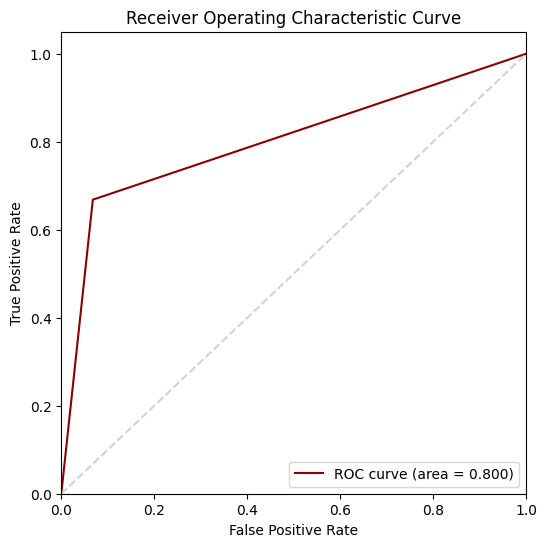

In [ ]:
X_train_a = augmented.drop('FraudFound_P', axis = 1)
y_train_a = augmented['FraudFound_P']

xgbr_3 = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    scale_pos_weight = 20,
    eval_metric = 'logloss'
)
xgbr_3.fit(X_train_a, y_train_a)
eval_result(xgbr_3, val_X, val_y, validation = True)

#### Decision Tree Classifier: AUC = 0.617


               precision    recall  f1-score   support

   Not Fraud       0.95      0.93      0.94      3183
       Fraud       0.22      0.31      0.25       208

    accuracy                           0.89      3391
   macro avg       0.58      0.62      0.60      3391
weighted avg       0.91      0.89      0.90      3391
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,2950,233
Fraud,144,64


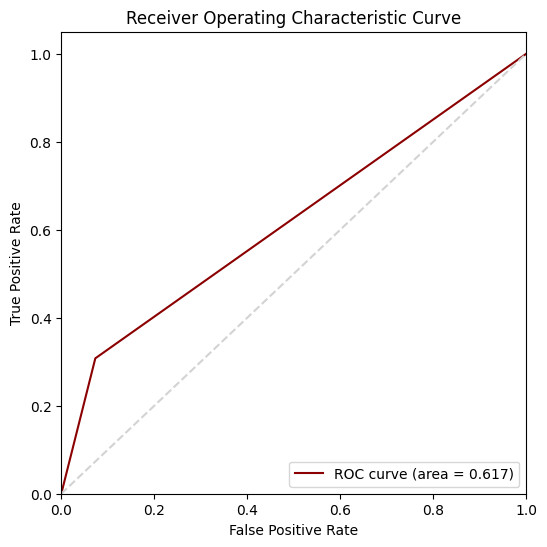

In [ ]:
dtc3 = DecisionTreeClassifier(random_state = 101)
dtc3.fit(X_train_a, y_train_a)
eval_result(dtc3, val_X, val_y, validation = True)

### Augmented data with synthetic generation (generation before preprocessing)

#### Data loading and split

In [ ]:
data2, validation2 = train_test_split(df, test_size = 0.3, random_state = 42)

In [ ]:
#Note: in order to use our generator, we need to make sure that the data type is constant within the different columns
data2['PastNumberOfClaims'] = data2['PastNumberOfClaims'].astype("string").astype('object')
data2['DayOfWeekClaimed'] = data2['DayOfWeekClaimed'].astype("string").astype('object')
data2['MonthClaimed'] = data2['MonthClaimed'].astype("string").astype('object')

#### Samples generation

In [ ]:
#Extracting the categorical columns
categorical_columns = []

for col in list(data2):
    if data2[col].dtypes == 'object':
        categorical_columns.append(col)

sensitive_columns = ['MaritalStatus']

fraud_data2 = data2[data2['FraudFound_P'] ==1]


fraud_generator2 = Generator(num_epochs=15,
                                  n_samples=1000,
                                  num_bootstrap = 50 ,
                                  architecture= 'RealTabFormer',
                                  data=fraud_data2,
                                  categorical_columns=categorical_columns,
                                  sensitive_columns=sensitive_columns)
    

#Generating the synthetic samples
synth_fraud2 = fraud_generator2.generate()

#Generating the augmented sample
augmented2 = pd.concat([synth_fraud2,data2],ignore_index=True, axis = 0)
augmented2 = augmented2.sample(frac=1).reset_index(drop=True)

Retrieving metadata, check with generator.metadata
Computing the sensitivity threshold...


/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:566: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 3...
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.003219
std       0.012910
min      -0.017405
25%      -0.005591
50%       0.000316
75%       0.010865
max       0.039979
dtype: float64
Sensitivity threshold: 0.027489451476793235 qt_max: 0.05


Map:   0%|          | 0/484 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
20,2.609800
40,1.358100
60,1.211900


  0%|          | 0/237 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 256 samples generated. Sampling efficiency is: 100.0000%
Critic round: 5,                     sensitivity_threshold: 0.027489451476793235,                         val_sensitivity: -0.0017651195499296774,                             val_sensitivities: [-0.010654008438818566, -0.008966244725738398, 0.007067510548523205, -0.014873417721518989, -0.0039029535864978913, -0.011497890295358651, -0.019936708860759496, 0.002848101265822785, -0.015717299578059073, -0.014873417721518989, 0.008755274261603377, 0.00959915611814346, 0.011286919831223626, 0.024789029535864978, 0.009599156118143458]


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
80,1.106300
100,1.089500
120,1.053300
140,1.021500


  0%|          | 0/237 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 256 samples generated. Sampling efficiency is: 100.0000%
Critic round: 10,                     sensitivity_threshold: 0.027489451476793235,                         val_sensitivity: 0.013368495077355835,                             val_sensitivities: [0.010443037974683544, 0.01719409282700422, 0.018881856540084386, 0.029852320675105487, 0.04082278481012658, 0.00791139240506329, 0.01128691983122363, 0.028164556962025314, 0.01550632911392405, 0.0020042194092826982, -0.0039029535864978913, 0.007067510548523206, 0.004535864978902952, 0.013818565400843882, -0.0030590717299578073]


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
160,0.996000
180,0.993800
200,0.975200
220,0.966500


  0%|          | 0/237 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 256 samples generated. Sampling efficiency is: 100.0000%
Critic round: 15,                     sensitivity_threshold: 0.027489451476793235,                         val_sensitivity: 0.013537271448663851,                             val_sensitivities: [0.00791139240506329, -0.0039029535864978913, 0.009599156118143458, 0.005379746835443035, 0.02310126582278481, 0.006223628691983121, 0.024789029535864978, 0.03322784810126582, 0.006223628691983121, -0.002215189873417723, 0.022257383966244725, 0.012130801687763712, 0.01719409282700422, 0.034071729957805906, 0.007067510548523205]


  0%|          | 0/1000 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1024 samples generated. Sampling efficiency is: 100.0000%


#### Preprocessing

In [ ]:
augmented_p = preprocessing(augmented2)
validation_p = preprocessing(validation2)

***Note***: since we carried out preprocessing (in particular one-hot encoding) after we split the `data` and `validation` sets, we have to now make sure that all the datasets we are considering for our evaluation have the same shape.

In [ ]:
for col in list(augmented_p):
  if col not in list(validation_p):
    validation_p[col] = 0

for col in list(validation_p):
  if col not in list(augmented_p):
    augmented_p[col] = 0

validation_p = validation_p[list(augmented_p)]

In [ ]:
print(augmented_p.shape)
print(validation_p.shape)

(8863, 76)
(3403, 76)


#### XGBoost: AUC = 0.854


               precision    recall  f1-score   support

   Not Fraud       0.99      0.92      0.95      3210
       Fraud       0.36      0.79      0.50       193

    accuracy                           0.91      3403
   macro avg       0.67      0.85      0.72      3403
weighted avg       0.95      0.91      0.92      3403
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,2941,269
Fraud,40,153


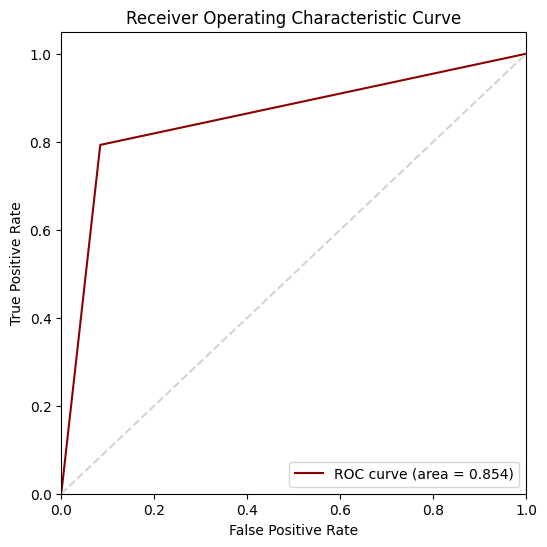

In [ ]:
X_train_a2 = augmented_p.drop('FraudFound_P', axis = 1)
y_train_a2 = augmented_p['FraudFound_P']

xgbr_4 = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    scale_pos_weight = 20,
    eval_metric = 'logloss'
)
xgbr_4.fit(X_train_a2, y_train_a2)
eval_result(xgbr_4, validation_p.drop('FraudFound_P', axis = 1), validation_p['FraudFound_P'], validation = True)

#### Decision Tree Classifier: AUC = 0.647


               precision    recall  f1-score   support

   Not Fraud       0.96      0.91      0.93      3210
       Fraud       0.20      0.39      0.26       193

    accuracy                           0.88      3403
   macro avg       0.58      0.65      0.60      3403
weighted avg       0.92      0.88      0.89      3403
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,2909,301
Fraud,118,75


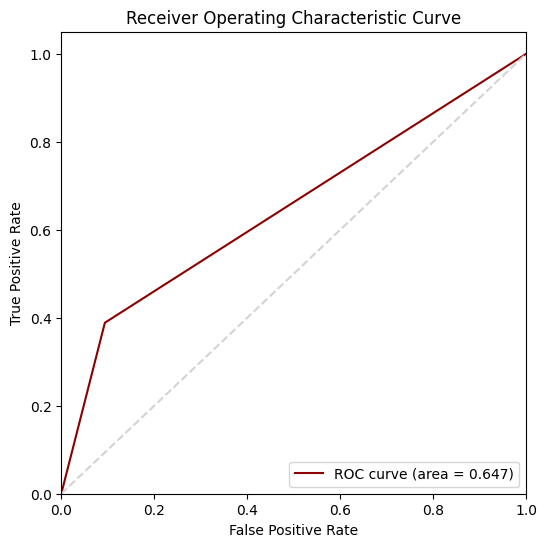

In [ ]:
dtc4 = DecisionTreeClassifier(random_state = 101)
dtc4.fit(X_train_a2, y_train_a2)
eval_result(dtc4, validation_p.drop('FraudFound_P', axis = 1), validation_p['FraudFound_P'], validation = True)